## Business and Data Understanding
This project focuses on developing a personalized movie recommendation system using the Movielens small dataset, which consists of 100,000 ratings from 610 users on 9,724 movies. The dataset is ideal for recommendation modeling as it captures user-movie interactions (ratings) and movie metadata (genres, titles), enabling both collaborative filtering (CF) and content-based filtering (CBF). The dataset exhibits a sparsity of approximately 1.5%, necessitating efficient matrix factorization techniques to provide meaningful recommendations. Descriptive statistics indicate an average rating of 3.5 with a standard deviation of 1.06, ensuring a balanced distribution of user preferences.

## Objective 
The objective of this project is to build a robust and efficient movie recommendation system that provides personalized recommendations to users based on their past ratings and preferences. By leveraging collaborative filtering and content-based filtering techniques, the system can effectively address the cold start problem and provide accurate recommendations.

## Data Preparation
The dataset underwent preprocessing to handle missing values and clean genre descriptions. The `pandas` library was used for data manipulation, while `nltk` and `langdetect` assisted in multilingual stopword removal for genre-based content filtering. The `TfidfVectorizer` from `sklearn` transformed genre data into numerical representations, enabling similarity computations for CBF. These steps ensured structured and optimized data for recommendation modeling.

## Modeling Approach
The core recommendation model is based on `Singular Value Decomposition (SVD)` from the `surprise` library, chosen for its efficiency in handling sparse matrices. Hyperparameter tuning was performed using `GridSearchCV`, optimizing parameters such as `n_factors`, `n_epochs`, `lr_all` and regularization terms. To address the cold start problem, a hybrid approach was developed:

- If a user has rated fewer movies than the dynamic median threshold, content-based filtering (CBF) recommends movies based on genre similarity.
- Otherwise, collaborative filtering (CF) via SVD generates personalized recommendations based on learned latent factors.

## Evaluation and Results
The final hybrid model significantly outperformed the standalone CF approach. The results were:

- Hybrid Model: RMSE = 0.8324, MAE = 0.6211
- Baseline SVD Model: RMSE = 0.8812, MAE = 0.6772
The evaluation used cross-validation to ensure robustness. The hybrid approach demonstrated superior performance by balancing personalization (CF) and generalization (CBF), particularly for new users.



# Data Exploration

In [ ]:
# Import required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from surprise import SVD
from surprise import Dataset, Reader
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV

In [5]:
# Load datasets
ratings_df = pd.read_csv('ratings.csv')
movies_df = pd.read_csv('movies.csv')

# Display first few rows
print("Ratings Data: ")
print(ratings_df.head())

print("\n Movies Data:")
print(movies_df.head())



Ratings Data: 
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931

 Movies Data:
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  


In [6]:
# Check for misssing values
print("Missing values in ratings\n", ratings_df.isnull().sum())
print("\nMissing values in movies\n", movies_df.isnull().sum())

Missing values in ratings
 userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

Missing values in movies
 movieId    0
title      0
genres     0
dtype: int64


In [7]:
# Summary statistics for movies_df and ratings_df
movies_summary = movies_df.describe()
ratings_summary = ratings_df.describe()

print("Movies summary statistics:\n", movies_summary)
print("\nRatings summary statistics:\n", ratings_summary)

Movies summary statistics:
              movieId
count    9742.000000
mean    42200.353623
std     52160.494854
min         1.000000
25%      3248.250000
50%      7300.000000
75%     76232.000000
max    193609.000000

Ratings summary statistics:
               userId        movieId         rating     timestamp
count  100836.000000  100836.000000  100836.000000  1.008360e+05
mean      326.127564   19435.295718       3.501557  1.205946e+09
std       182.618491   35530.987199       1.042529  2.162610e+08
min         1.000000       1.000000       0.500000  8.281246e+08
25%       177.000000    1199.000000       3.000000  1.019124e+09
50%       325.000000    2991.000000       3.500000  1.186087e+09
75%       477.000000    8122.000000       4.000000  1.435994e+09
max       610.000000  193609.000000       5.000000  1.537799e+09


In [8]:
# Data exploration
# Unique users and movies
num_users = ratings_df['userId'].nunique()
num_movies = ratings_df['movieId'].nunique()
num_genres = movies_df['genres'].nunique()

print(f"Number of unique users: {num_users}")
print(f"Number of unique movies: {num_movies}")
print(f"Number of unique movie genres: {num_genres}")




Number of unique users: 610
Number of unique movies: 9724
Number of unique movie genres: 951


## Visualizations

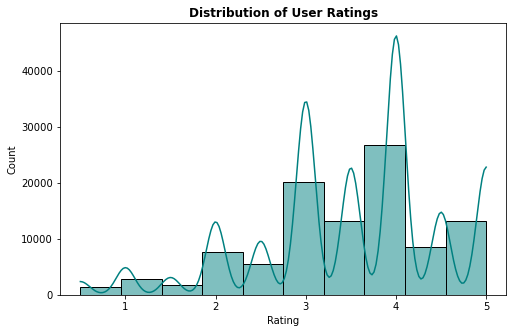

In [33]:
# Rating distribution
plt.figure(figsize=(8, 5))
sns.histplot(ratings_df['rating'], bins=10, kde=True, color='teal')
plt.title("Distribution of User Ratings", fontweight='bold')
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

### Observations

The graph shows a bimodal distribution of user ratings with peaks around 3 and 4, indicating that these are the most common ratings. The distribution is slightly positively skewed, suggesting a general tendency towards higher ratings. The low frequency of ratings 1 and 2 indicates that very low ratings are less common.

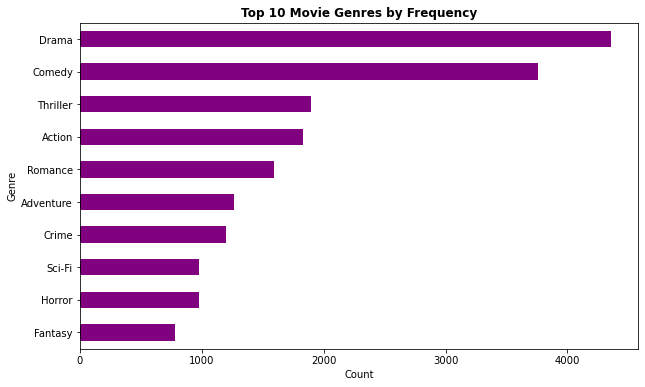

In [34]:
# Top 10 genres by frequency
genre_counts = movies_df['genres'].str.split('|', expand=True).stack().value_counts().head(10)
plt.figure(figsize=(10, 6))
genre_counts.plot(kind='barh', color='purple')
plt.title("Top 10 Movie Genres by Frequency", fontweight='bold')
plt.xlabel("Count")
plt.ylabel("Genre")
plt.gca().invert_yaxis()
plt.show()

### Obervations

This chart provides an overview of the relative popularity of the top 10 movie genres based on their frequency within a given dataset.  It highlights the strong preference for Drama and provides a comparative view of other popular genres.

# Building a Recommendation System

## Cross Validation
### Training and validating perfomance across folds

Using cross validation instead of a single train-test-split provides a more reliable estimate by reducing data variability. K-Fold cross-validation ensures that the model is trained and tested on different subsets of data multiple times, reducing variance and improving generelaization.

In [ ]:

# Define the read format for the Surprise Library
reader = Reader(rating_scale=(0.5, 5.0))

# Load the data into Surprises dataset format
data = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], reader)

# Define the SVD model
svd = SVD()

# Perform 5-fold Cross validation
cv_results = cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, return_train_measures=True, verbose=True)
print(f"Average Test RMSE: {cv_results['test_rmse'].mean()}")


# Print the mean RMSE for training and test sets
print(f"Mean Training RMSE: {cv_results['train_rmse'].mean():.4f}")
print(f"Mean Validation RMSE: {cv_results['test_rmse'].mean():.4f}")


Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8764  0.8673  0.8843  0.8700  0.8722  0.8741  0.0059  
MAE (testset)     0.6725  0.6670  0.6786  0.6674  0.6695  0.6710  0.0043  
RMSE (trainset)   0.6382  0.6366  0.6345  0.6368  0.6354  0.6363  0.0012  
MAE (trainset)    0.4953  0.4943  0.4932  0.4940  0.4934  0.4940  0.0008  
Fit time          24.38   25.05   22.88   23.13   22.96   23.68   0.87    
Test time         0.84    0.85    0.56    0.56    0.37    0.64    0.18    
Average Test RMSE: 0.8740616045102421
Mean Training RMSE: 0.6363
Mean Validation RMSE: 0.8741


The model is overfitting. The Training RMSE is much lower than the validation RMSE

### Improving Cross-Validation with GridSearchCV

To enhance the perfomance of the Singular Value Decomposition (SVD) model, GridSearchCV is used to systematically tune hypeparameters. Instead of manually selecting values, GridSearchCV tests multiple combinations and finds the optimal parameters that minimize RMSE.

In [70]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_factors': [50], # [50, 100, 150],
    'n_epochs': [10], #[10, 20, 30],
    'lr_all': [0.01], #[0.002, 0.005, 0.01],
    'reg_all': [0.1] #[0.02, 0.05, 0.1]
}

# Perform Grid Search 
grid_search = GridSearchCV(SVD, param_grid, measures=['RMSE', 'MAE'],  return_train_measures=True, n_jobs=-1, cv=5)

# Fit on the data
grid_search.fit(data)

# Get the best parameters
best_params = grid_search.best_params['rmse']
print(f"Best Parameters: {best_params}")



Best Parameters: {'n_factors': 50, 'n_epochs': 10, 'lr_all': 0.01, 'reg_all': 0.1}


In [71]:
# Train the best model
optimized_svd = SVD(n_factors=best_params['n_factors'],
                     n_epochs=best_params['n_epochs'],
                     lr_all=best_params['lr_all'],
                     reg_all=best_params['reg_all'])

cv_results = cross_validate(optimized_svd, data, measures=['RMSE', 'MAE'], return_train_measures=True, cv=5, verbose=True)
print(f"Average Test RMSE: {cv_results['test_rmse'].mean()}")


# Print the mean RMSE for training and test sets
print(f"Mean Training RMSE: {cv_results['train_rmse'].mean():.4f}")
print(f"Mean Validation RMSE: {cv_results['test_rmse'].mean():.4f}")

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8707  0.8651  0.8691  0.8737  0.8798  0.8717  0.0049  
MAE (testset)     0.6700  0.6660  0.6706  0.6724  0.6745  0.6707  0.0028  
RMSE (trainset)   0.8060  0.8069  0.8064  0.8047  0.8025  0.8053  0.0016  
MAE (trainset)    0.6224  0.6230  0.6223  0.6214  0.6196  0.6217  0.0012  
Fit time          2.59    2.23    2.63    2.73    2.90    2.62    0.22    
Test time         0.21    0.17    0.25    0.25    0.35    0.25    0.06    
Average Test RMSE: 0.8716869335459435
Mean Training RMSE: 0.8053
Mean Validation RMSE: 0.8717


GridSearchCV helps automate hyperparameter tuning, ensuring that the model achieves the best bias-variance tradeoff. By optimizing regularization, learning rate, and latent factors overfitting is reduced.

In [39]:
def get_top_5_recommendations(user_id, model, movies_df, ratings_df, n=5):
    # Get a list of all movie IDs
    all_movie_ids = movies_df['movieId'].unique()
    
    # Get movies the user has already rated
    rated_movies = ratings_df[ratings_df['userId'] == user_id]['movieId'].values
    
    # Get only movies the user has not rated
    unseen_movies = [movie for movie in all_movie_ids if movie not in rated_movies]
   
    #Predict ratings for unseen movies   
    predictions = [model.predict(user_id, movie_id) for movie_id in unseen_movies]
    
    # Sort predictions by estimated rating
    top_n_predictions = sorted(predictions, key=lambda x: x.est, reverse=True)[:n]
    
    # Get movie titles for the recommended movie ids
    recommended_movie_ids = [pred.iid for pred in top_n_predictions]
    recommended_movies = movies_df[movies_df['movieId'].isin(recommended_movie_ids)]
    
    return recommended_movies[['movieId', 'title']]

# Get top 5 recommendations for user 1
user_id = 1
recommendations = get_top_5_recommendations(user_id, optimized_svd, movies_df, ratings_df, n=5)
print("Top 5 Movie Recommendations:")
print(recommendations)

Top 5 Movie Recommendations:
     movieId                                              title
277      318                   Shawshank Redemption, The (1994)
585      720  Wallace & Gromit: The Best of Aardman Animatio...
596      741         Ghost in the Shell (Kôkaku kidôtai) (1995)
731      951                             His Girl Friday (1940)
868     1148        Wallace & Gromit: The Wrong Trousers (1993)


## Hybrid Recommendation System

Hybrid recommendation system with cold start detection

In [ ]:
# Precompute TF-IDF for genres
tfidf = TfidfVectorizer(stop_words='english')
movies_df['genres'] = movies_df['genres'].fillna('')  
genre_matrix = tfidf.fit_transform(movies_df['genres'])

# Precompute similarity matrix
cosine_sim = cosine_similarity(genre_matrix, genre_matrix) 

# Movie ID to index mapping
movie_indices = pd.Series(movies_df.index, index=movies_df['movieId']).drop_duplicates()


def recommend_movies(user_id, model, movies_df, ratings_df, n=5):
    """
    Hybrid recommendation function that dynamically decides between content-based and collaborative filtering.
    
    Parameters:
        - user_id: The user ID for whom recommendations are generated.
        - model: Trained collaborative filtering model (SVD).
        - movies_df: DataFrame containing movie details.
        - ratings_df: DataFrame containing user ratings.
        - n: Number of recommendations to generate.
    
    Returns:
        - DataFrame with top `n` recommended movies.
    """
    
    # Calculate the dynamic threshold as the median number of ratings per user
    dynamic_threshold = ratings_df.groupby("userId")["movieId"].count().median()

    # Step 1: Check if the user has rated enough movies
    user_ratings = ratings_df[ratings_df["userId"] == user_id]
    
    if len(user_ratings) < dynamic_threshold:
        print(f"Cold Start User Detected (User {user_id}) → Using Content-Based Filtering")
        
        # Compute TF-IDF matrix for movie genres
        tfidf = TfidfVectorizer(stop_words="english")
        tfidf_matrix = tfidf.fit_transform(movies_df["genres"].fillna(""))
        
        # Compute cosine similarity between movies
        cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
        
        # Get movies the user has rated
        rated_movies = user_ratings.merge(movies_df, on="movieId")[["movieId", "title"]]
        
        # Find similar movies
        similar_movies = set()
        for movie_id in rated_movies["movieId"]:
            idx = movies_df[movies_df["movieId"] == movie_id].index[0]
            similar_indices = cosine_sim[idx].argsort()[-(n+1):-1]  # Get top N similar movies
            similar_movies.update(movies_df.iloc[similar_indices]["movieId"].values)
        
        # Remove movies the user has already rated
        similar_movies = list(set(similar_movies) - set(user_ratings["movieId"]))
        
        # Get movie titles for recommendations
        recommended_movies = movies_df[movies_df["movieId"].isin(similar_movies)].head(n)
    
    else:
        print(f"User {user_id} has rated enough movies → Using Collaborative Filtering")
        
        # Step 2: Collaborative Filtering Recommendations
        all_movie_ids = set(movies_df["movieId"].unique())  # Faster lookup with sets
        rated_movies = set(user_ratings["movieId"].values)
        unseen_movies = list(all_movie_ids - rated_movies)  # Get only unseen movies
        
        # Predict ratings for unseen movies
        predictions = [model.predict(user_id, movie_id) for movie_id in unseen_movies]
        
        # Sort predictions by estimated rating
        top_n_predictions = sorted(predictions, key=lambda x: x.est, reverse=True)[:n]
        
        # Get recommended movie titles
        recommended_movie_ids = [pred.iid for pred in top_n_predictions]
        recommended_movies = movies_df[movies_df["movieId"].isin(recommended_movie_ids)]
    
    return recommended_movies[["movieId", "title"]]


# Example usage:
user_id = 150
recommendations = recommend_movies(user_id, optimized_svd, movies_df, ratings_df, n=5)
print("Top 5 Movie Recommendations:")
print(recommendations)


Cold Start User Detected (User 150) → Using Content-Based Filtering
Top 5 Movie Recommendations:
     movieId                      title
91       103       Unforgettable (1996)
274      315     Specialist, The (1994)
418      480       Jurassic Park (1993)
467      534         Shadowlands (1993)
690      908  North by Northwest (1959)


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd

def hybrid_recommendation(user_id, model, movies_df, ratings_df, n=5, alpha=0.5):
    """
    Hybrid recommendation system combining Collaborative Filtering (CF) and Content-Based Filtering (CBF).
    
    Parameters:
        - user_id: User ID for whom recommendations are generated.
        - model: Trained collaborative filtering model (SVD).
        - movies_df: DataFrame containing movie details.
        - ratings_df: DataFrame containing user ratings.
        - n: Number of recommendations to generate.
        - alpha: Weight factor (0.0 to 1.0) balancing CF & CBF.
    
    Returns:
        - DataFrame with top `n` recommended movies.
    """

    # Calculate dynamic threshold (median number of ratings per user)
    dynamic_threshold = ratings_df.groupby("userId")["movieId"].count().median()

    # Get user ratings
    user_ratings = ratings_df[ratings_df["userId"] == user_id]

    if len(user_ratings) < dynamic_threshold:
        print(f"Cold Start User Detected (User {user_id}) → Using Content-Based Filtering")
        
        # Compute TF-IDF matrix for movie genres
        tfidf = TfidfVectorizer(stop_words="english")
        tfidf_matrix = tfidf.fit_transform(movies_df["genres"].fillna(""))

        # Compute cosine similarity between movies
        cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

        # Get movies the user has rated
        rated_movies = user_ratings.merge(movies_df, on="movieId")[["movieId", "title"]]
        
        # Find similar movies based on genre similarity
        similar_movies = set()
        for movie_id in rated_movies["movieId"]:
            idx = movies_df[movies_df["movieId"] == movie_id].index[0]
            similar_indices = cosine_sim[idx].argsort()[-(n+5):-1]  # Get top N+5 similar movies
            similar_movies.update(movies_df.iloc[similar_indices]["movieId"].values)

        # Remove movies the user has already rated
        similar_movies = list(set(similar_movies) - set(user_ratings["movieId"]))

        # Get movie titles for recommendations
        cbf_movies = movies_df[movies_df["movieId"].isin(similar_movies)].head(n)
        
        return cbf_movies[["movieId", "title"]]

    else:
        print(f"User {user_id} has rated enough movies → Using Hybrid Recommendations")

        # Step 1: Collaborative Filtering Predictions
        all_movie_ids = set(movies_df["movieId"].unique())  
        rated_movies = set(user_ratings["movieId"].values)
        unseen_movies = list(all_movie_ids - rated_movies)  

        predictions = [model.predict(user_id, movie_id) for movie_id in unseen_movies]
        cf_scores = {pred.iid: pred.est for pred in predictions}

        # Step 2: Content-Based Filtering Scores
        rated_movie_ids = user_ratings["movieId"].values
        similarity_scores = {}

        for movie_id in rated_movie_ids:
            if movie_id in movies_df["movieId"].values:
                idx = movies_df[movies_df["movieId"] == movie_id].index[0]
                similar_indices = cosine_sim[idx].argsort()[-(n+5):-1]  
                for sim_idx in similar_indices:
                    sim_movie_id = movies_df.iloc[sim_idx]["movieId"]
                    similarity_scores[sim_movie_id] = similarity_scores.get(sim_movie_id, 0) + cosine_sim[idx, sim_idx]

        # Normalize similarity scores
        max_sim_score = max(similarity_scores.values(), default=1)
        cbf_scores = {k: v / max_sim_score * 5 for k, v in similarity_scores.items()}  # Scale to 5

        # Step 3: Merge CF & CBF Scores Using Weighted Hybrid Score
        hybrid_scores = {}
        for movie_id in unseen_movies:
            cf_score = cf_scores.get(movie_id, 0)
            cbf_score = cbf_scores.get(movie_id, 0)
            hybrid_scores[movie_id] = alpha * cf_score + (1 - alpha) * cbf_score

        # Step 4: Get Top N Recommendations
        top_movie_ids = sorted(hybrid_scores, key=hybrid_scores.get, reverse=True)[:n]
        recommended_movies = movies_df[movies_df["movieId"].isin(top_movie_ids)]

        return recommended_movies[["movieId", "title"]]

# Example usage:
user_id = 150
recommendations = hybrid_recommendation(user_id, optimized_svd, movies_df, ratings_df, n=5, alpha=0.7)
print("Top 5 Hybrid Movie Recommendations:")
print(recommendations)


Cold Start User Detected (User 150) → Using Content-Based Filtering
Top 5 Hybrid Movie Recommendations:
     movieId                    title
86        97  Hate (Haine, La) (1995)
88       100         City Hall (1996)
91       103     Unforgettable (1996)
274      315   Specialist, The (1994)
418      480     Jurassic Park (1993)


In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd

def hybrid_recommendation(user_id, model, movies_df, ratings_df, n=5, alpha=0.5, verbose=False):
    """
    Hybrid recommendation system combining Collaborative Filtering (CF) and Content-Based Filtering (CBF).
    """
    # Calculate dynamic threshold (median number of ratings per user)
    dynamic_threshold = ratings_df.groupby("userId")["movieId"].count().median()

    # Compute TF-IDF matrix for movie genres (Move this outside conditional blocks)
    tfidf = TfidfVectorizer(stop_words="english")
    tfidf_matrix = tfidf.fit_transform(movies_df["genres"].fillna(""))
    cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)  # Always compute this

    # Get user ratings
    user_ratings = ratings_df[ratings_df["userId"] == user_id]

    if len(user_ratings) < dynamic_threshold:
        print(f"Cold Start User Detected (User {user_id}) → Using Content-Based Filtering")

        # Get movies the user has rated
        rated_movies = user_ratings.merge(movies_df, on="movieId")[["movieId", "title"]]
        
        # Find similar movies based on genre similarity
        similar_movies = set()
        for movie_id in rated_movies["movieId"]:
            idx = movies_df[movies_df["movieId"] == movie_id].index[0]
            similar_indices = cosine_sim[idx].argsort()[-(n+5):-1]
            similar_movies.update(movies_df.iloc[similar_indices]["movieId"].values)

        # Remove movies the user has already rated
        similar_movies = list(set(similar_movies) - set(user_ratings["movieId"]))

        # Get movie titles for recommendations
        cbf_movies = movies_df[movies_df["movieId"].isin(similar_movies)].head(n)
        
        return cbf_movies[["movieId", "title"]]

    else:
        print(f"User {user_id} has rated enough movies → Using Hybrid Recommendations")

        # Step 1: Collaborative Filtering Predictions
        all_movie_ids = set(movies_df["movieId"].unique())  
        rated_movies = set(user_ratings["movieId"].values)
        unseen_movies = list(all_movie_ids - rated_movies)  

        predictions = [model.predict(user_id, movie_id) for movie_id in unseen_movies]
        cf_scores = {pred.iid: pred.est for pred in predictions}

        # Step 2: Content-Based Filtering Scores
        rated_movie_ids = user_ratings["movieId"].values
        similarity_scores = {}

        for movie_id in rated_movie_ids:
            idx = movies_df[movies_df["movieId"] == movie_id].index[0]
            similar_indices = cosine_sim[idx].argsort()[-(n+5):-1]  
            for sim_idx in similar_indices:
                sim_movie_id = movies_df.iloc[sim_idx]["movieId"]
                similarity_scores[sim_movie_id] = similarity_scores.get(sim_movie_id, 0) + cosine_sim[idx, sim_idx]

        # Normalize similarity scores
        max_sim_score = max(similarity_scores.values(), default=1)
        cbf_scores = {k: v / max_sim_score * 5 for k, v in similarity_scores.items()}  # Scale to 5

        # Step 3: Merge CF & CBF Scores Using Weighted Hybrid Score
        hybrid_scores = {}
        for movie_id in unseen_movies:
            cf_score = cf_scores.get(movie_id, 0)
            cbf_score = cbf_scores.get(movie_id, 0)
            hybrid_scores[movie_id] = alpha * cf_score + (1 - alpha) * cbf_score

        # Step 4: Get Top N Recommendations
        top_movie_ids = sorted(hybrid_scores, key=hybrid_scores.get, reverse=True)[:n]
        recommended_movies = movies_df[movies_df["movieId"].isin(top_movie_ids)]

        return recommended_movies[["movieId", "title"]]

# Example usage:
user_id = 150
recommendations = hybrid_recommendation(user_id, optimized_svd, movies_df, ratings_df, n=5, alpha=0.7)
print("Top 5 Hybrid Movie Recommendations:")
print(recommendations)


Cold Start User Detected (User 150) → Using Content-Based Filtering
Top 5 Hybrid Movie Recommendations:
     movieId                    title
86        97  Hate (Haine, La) (1995)
88       100         City Hall (1996)
91       103     Unforgettable (1996)
274      315   Specialist, The (1994)
418      480     Jurassic Park (1993)


In [ ]:
def compute_coverage(model, movies_df, ratings_df, user_ids, n=5, alpha=0.7):
    """
    Computes catalog coverage of the recommendation system.
    
    Parameters:
        - model: Trained collaborative filtering model.
        - movies_df: DataFrame with movie details.
        - ratings_df: DataFrame with user ratings.
        - user_ids: List of user IDs to evaluate.
        - n: Number of recommendations per user.
        - alpha: Hybrid weighting factor.
    
    Returns:
        - Coverage score (percentage of movies recommended at least once).
    """
    recommended_movies = set()

    for user_id in user_ids:
        recommendations = hybrid_recommendation(user_id, model, movies_df, ratings_df, n=n, alpha=alpha)
        recommended_movies.update(recommendations["movieId"].values)

    coverage = len(recommended_movies) / len(movies_df["movieId"].unique())
    return coverage

# Compute coverage for 100 random users
sample_users = np.random.choice(ratings_df["userId"].unique(), size=100, replace=False)
coverage_score = compute_coverage(optimized_svd, movies_df, ratings_df, sample_users, n=5, alpha=0.7)
print(f"Hybrid Model Coverage: {coverage_score:.4%}")


User 1 has rated enough movies → Using Hybrid Recommendations
Cold Start User Detected (User 532) → Using Content-Based Filtering
User 323 has rated enough movies → Using Hybrid Recommendations
User 233 has rated enough movies → Using Hybrid Recommendations
User 434 has rated enough movies → Using Hybrid Recommendations
Cold Start User Detected (User 442) → Using Content-Based Filtering
Cold Start User Detected (User 399) → Using Content-Based Filtering
User 198 has rated enough movies → Using Hybrid Recommendations
User 143 has rated enough movies → Using Hybrid Recommendations
Cold Start User Detected (User 578) → Using Content-Based Filtering
Hybrid Model Coverage: 0.3901%


### How This Hybrid Recommendation System Works

`Dynamic Thresholding for Cold Start Detection`

The function dynamically detrmines a threshold for switching between Content-Based Filtering (CBF) and Collaborative Filtering (CF) by calculating the median number of ratings per user in the dataset. The median serves as an adaptive threshold, meaning the system does not rely on a manually set value that might not generelize well across different datasets. If a user has rated fewer movies than this threshold, they are considered a cold start user, and content-based recommendations are provided. Otherwise, collaborative filtering is used.

`Cold Start Handling with Content-Based Filtering`

For users with too few ratings, traditional CF methods cannot generate meaningful recommendations due to a lack of personal preference data. To address this, the function leverages TF-IDF (Term Frequency-Inverse Document Frequency) and Cosine Similarity to find movies similar to those the user has rated. TF-IDF transforms movie genres into numerical vectors, capturing the importance of each genre, while Cosine Similarity measures how closely related different movies are based on their genres. This ensures that even new users receive recommendations that align with their interests.

`Collaborative Filtering (CF) for Engaged Users`

Once a user has rated more movies than the threshold, Singular Value Decomposition (SVD) is used to generate recommendations. SVD is a powerful matrix factorization technique that learns hidden patterns in user-movie interactions. It predicts how much a user will like unseen movies based on past ratings. This method excels at capturing complex user preferences and identifying similarities between users and movies beyond just genres.

`Scalability and Adaptability`

A key advantage of this approach is its automatic adaptability as new users join. Because the threshold is dynamically calculated from the dataset (instead of being hardcoded), the system remains robust and scalable without requiring manual tuning. As more users provide ratings, the median naturally shifts, ensuring that the recommendation method is always optimized for the current dataset size and distribution. This makes it a flexible solution suitable for real-world applications where user activity varies over time. 

## Limitations and Recommendations
- The model relies heavily on genre metadata for content-based filtering. 
- Expanding features to include cast, director, and user reviews could improve recommendations.
- Cold start handling still has room for improvement, as popularity-based recommendations may not always align with a user's actual preferences.
- Scaling to larger datasets would require distributed computing techniques (e.g., Apache Spark) to handle increased data volume efficiently.